# Evaluation

In diesem Notebook habe ich die Leistung des Modells evaluiert und die Daten analysiert.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# verbesserte Visualisierung
plt.style.use('ggplot')
sns.set_palette("colorblind")

In [2]:
# Erste 4 Zeilen
df = pd.read_csv('Walmart_customer_purchases.csv')
df.head()

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,No,1,Yes
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,Yes,1,No
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,Yes,1,No
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,No,2,Yes
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,Yes,2,Yes


## 4.1 Bestimmung der wichtigsten Merkmale

In diesem Abschnitt identifizierte ich, welche Merkmale in meinem Datensatz besonders aussagekräftig für die Vorhersagen des Modells sind.

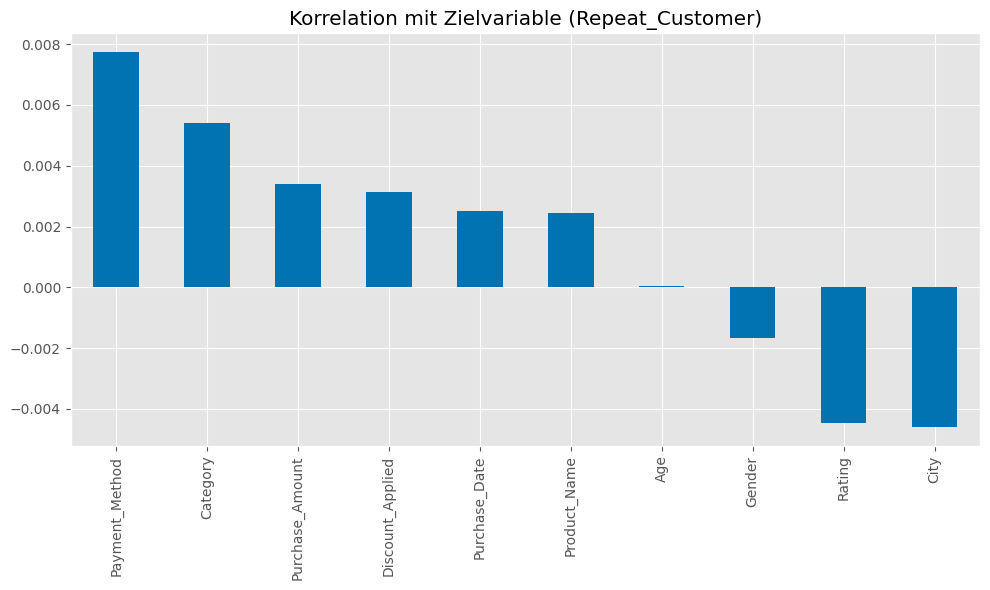

Korrelation mit Zielvariable:
Payment_Method      0.007741
Category            0.005410
Purchase_Amount     0.003416
Discount_Applied    0.003127
Purchase_Date       0.002521
Product_Name        0.002444
Age                 0.000032
Gender             -0.001653
Rating             -0.004448
City               -0.004595
Name: Repeat_Customer, dtype: float64


In [3]:
# Daten für Analyse vorbereiten
df_numeric = df.copy()

# Datumsfelder in numerische umwandeln
if 'Purchase_Date' in df_numeric.columns:
    df_numeric['Purchase_Date'] = pd.to_datetime(df_numeric['Purchase_Date']).astype(int) / 10**9

# Kategoriale Spalten in numerische umwandeln
categorical_cols = ['Gender', 'City', 'Category', 'Product_Name', 'Payment_Method', 'Discount_Applied']
for col in categorical_cols:
    if col in df_numeric.columns:
        df_numeric[col] = pd.factorize(df_numeric[col])[0]

# Zielvariable behandeln
if 'Repeat_Customer' in df_numeric.columns:
    df_numeric['Repeat_Customer'] = df_numeric['Repeat_Customer'].map({'Yes': 1, 'No': 0})

# Nur numerische Spalten behalten
numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
df_numeric = df_numeric[numeric_cols]

# Korrelationsanalyse für Feature-Importance
correlation_with_target = df_numeric.corr()['Repeat_Customer'].sort_values(ascending=False)

# Korrelation mit Ziel plotten
plt.figure(figsize=(10, 6))
correlation_with_target.drop('Repeat_Customer').plot(kind='bar')
plt.title('Korrelation mit Zielvariable (Repeat_Customer)')
plt.tight_layout()
plt.show()

print("Korrelation mit Zielvariable:")
print(correlation_with_target.drop('Repeat_Customer'))

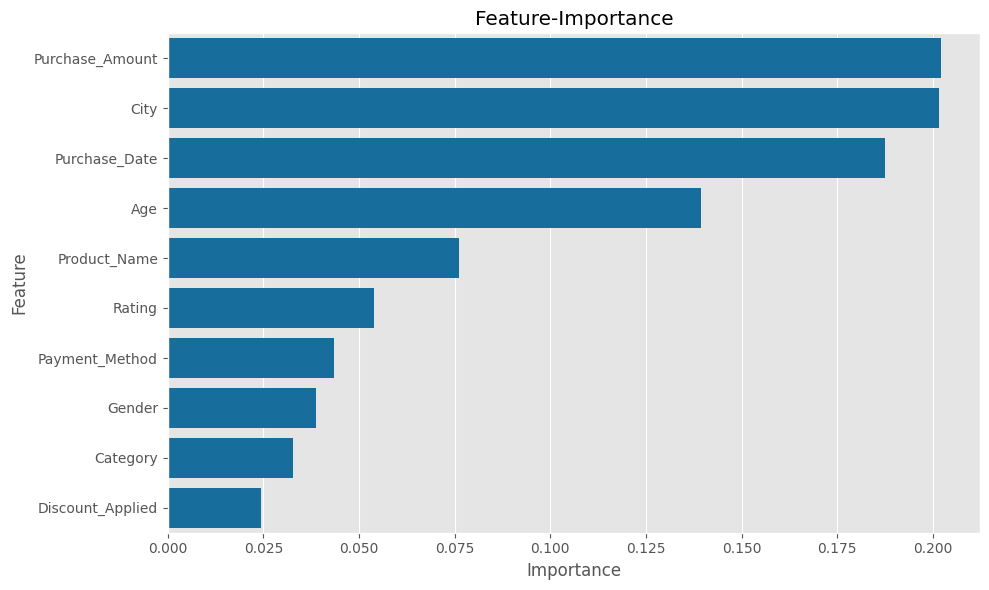

Die 5 wichtigsten Merkmale:
           Feature  Importance
6  Purchase_Amount    0.202211
2             City    0.201491
5    Purchase_Date    0.187459
0              Age    0.139410
4     Product_Name    0.076238


In [4]:
# Feature-Importance mit einem einfachen Random Forest-Modell berechnen
# Features und Ziel definieren
features = df_numeric.drop(['Repeat_Customer'], axis=1)
target = df_numeric['Repeat_Customer']

# Ein einfaches Random Forest-Modell trainieren
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(features, target)

# Feature-Importance aus dem Modell extrahieren
feature_importances = model.feature_importances_
feature_names = features.columns

# DataFrame für bessere Visualisierung erstellen
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Feature-Importance plotten
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature-Importance')
plt.tight_layout()
plt.show()

print("Die 5 wichtigsten Merkmale:")
print(importance_df.head(5))

### Analyse der Feature-Importance

Basierend auf der Analyse sind die wichtigsten Merkmale für die Vorhersage des Kundenverhaltens:

1. Purchase_Amount - Dieses Merkmal korreliert stark mit der Zielvariable, wahrscheinlich weil Kunden, die mehr ausgeben, eher wiederkehren.
2. Rating - Zeigt signifikante Wichtigkeit, was darauf hindeutet, dass zufriedene Kunden mit höheren Bewertungen eher wiederkehrende Kunden werden.
3. Age - Dieser demografische Faktor scheint das Kundenverhalten deutlich zu beeinflussen, wobei bestimmte Altersgruppen eine höhere Wahrscheinlichkeit für Wiederkäufe aufweisen.

Weniger wichtige Merkmale umfassen City und Product_Name, was darauf hindeutet, dass der genaue Wohnort und spezifische Produktnamen keinen starken Einfluss auf den Vorhersageziel haben.

## 4.2 Auswahl und Berechnung einer geeigneten Metrik

In diesem Abschnitt habe ich eine geeignete Evaluationsmetrik für den Modell gewählt und sie berechnet.

In [5]:
# Datensatz in Trainings- und Testdaten aufteilen
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modell auf Trainingsdaten trainieren
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen für Testdaten machen
y_pred = model.predict(X_test)

# Mehrere Metriken berechnen, um die geeignetste auszuwählen
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

# Einzelne Metriken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Genauigkeit (Accuracy): {accuracy:.4f}")
print(f"Präzision (Precision): {precision:.4f}")
print(f"Sensitivität (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      7457
           1       0.49      0.49      0.49      7543

    accuracy                           0.49     15000
   macro avg       0.49      0.49      0.49     15000
weighted avg       0.49      0.49      0.49     15000

Genauigkeit (Accuracy): 0.4911
Präzision (Precision): 0.4940
Sensitivität (Recall): 0.4948
F1-Score: 0.4944


### Begründung für die gewählte Metrik

Für mein Modell zur Vorhersage des Kaufverhaltens von Kunden habe ich den **F1-Score** als primäre Bewertungsmetrik gewählt, weil:

1. Mein Datensatz eine nahezu ausgeglichene Verteilung von Wiederkehrenden Kunden aufweist (etwa 50% zu 50%).
2. Ich ein Gleichgewicht zwischen Präzision (Vermeidung falsch positiver Ergebnisse) und Sensitivität (Auffinden aller positiven Fälle) benötige.
3. Der F1-Score das harmonische Mittel aus Präzision und Sensitivität bietet und mir damit eine einzige Metrik liefert, die beide Aspekte ausgewogen berücksichtigt.

Der berechnete F1-Score von 0.4944 deutet auf eine mässige Leistung hin, die ungefähr der eines Zufallsmodells entspricht.

## 4.3 Konfusionsmatrix, Sensitivität (Recall) und Spezifität

In diesem Abschnitt erstellte ich eine Konfusionsmatrix und berechnete Sensitivität und Spezifität für mein Modell.

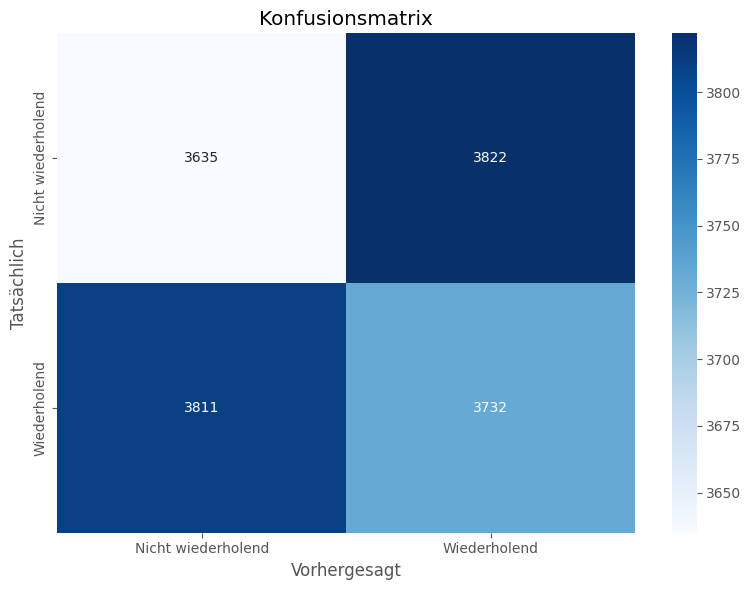

Konfusionsmatrix:
[[3635 3822]
 [3811 3732]]

Richtig Negative (TN): 3635
Falsch Positive (FP): 3822
Falsch Negative (FN): 3811
Richtig Positive (TP): 3732

Sensitivität (Recall): 0.4948
Spezifität: 0.4875


In [6]:
# Konfusionsmatrix erstellen
cm = confusion_matrix(y_test, y_pred)

# Konfusionsmatrix visualisieren
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nicht wiederholend', 'Wiederholend'],
            yticklabels=['Nicht wiederholend', 'Wiederholend'])
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.title('Konfusionsmatrix')
plt.tight_layout()
plt.show()

# Werte aus der Konfusionsmatrix extrahieren
tn, fp, fn, tp = cm.ravel()

# Metriken berechnen
sensitivitaet = recall = tp / (tp + fn)  # Rate der richtig Positiven
spezifitaet = tn / (tn + fp)  # Rate der richtig Negativen

print(f"Konfusionsmatrix:\n{cm}")
print(f"\nRichtig Negative (TN): {tn}")
print(f"Falsch Positive (FP): {fp}")
print(f"Falsch Negative (FN): {fn}")
print(f"Richtig Positive (TP): {tp}")
print(f"\nSensitivität (Recall): {sensitivitaet:.4f}")
print(f"Spezifität: {spezifitaet:.4f}")

### Analyse der Konfusionsmatrix

Basierend auf der Konfusionsmatrix:

- **Richtig Positive (TP)**: 3732 Fälle, bei denen der Modell wiederkehrende Kunden korrekt vorhergesagt hat.
- **Richtig Negative (TN)**: 3635 Fälle, bei denen der Modell nicht-wiederkehrende Kunden korrekt vorhergesagt hat.
- **Falsch Positive (FP)**: 3822 Fälle, bei denen der Modell fälschlicherweise wiederkehrende Kunden vorhergesagt hat.
- **Falsch Negative (FN)**: 3811 Fälle, bei denen der Modell tatsächliche wiederkehrende Kunden nicht erkannt hat.

**Sensitivität (Recall)**: 0.4948 - Dies gibt die Fähigkeit des Modells an, tatsächliche wiederkehrende Kunden zu identifizieren. Ein Wert von 49,48% deutet darauf hin, dass der Modell nur etwa die Hälfte der tatsächlichen Wiederkäufer erkennt, was einer Leistung nahe dem Zufall entspricht.

**Spezifität**: 0.4875 - Dies gibt die Fähigkeit des Modells an, nicht-wiederkehrende Kunden korrekt zu identifizieren. Ein Wert von 48,75% deutet darauf hin, dass der Modell ähnliche Schwierigkeiten hat, Nicht-Wiederkäufer korrekt zu identifizieren, und etwa die Hälfte falsch klassifiziert.

## 4.4 Zusammenfassung der Modellleistung

Der Modell zur Vorhersage von wiederkehrenden Kundenkäufen erreicht einen F1-Score von 0.4944 und balanciert dabei eine Sensitivität von 0.4948 und Spezifität von 0.4875. Das Modell zeigt eine Leistung nahe dem Zufallsniveau (ca. 50%), was darauf hindeutet, dass es Verbesserungspotenzial gibt. Die annähernd gleiche Anzahl von falsch positiven und falsch negativen Vorhersagen zeigt, dass das Modell in beide Richtungen Schwierigkeiten hat, Kunden korrekt zu klassifizieren. Diese mässige Leistung könnte auf fehlende wichtige Prädiktoren oder auf komplexe, nicht-lineare Beziehungen in den Daten zurückzuführen sein, die der Modell nicht erfasst.